In [3]:
# Install packages
%pip install networkx
%pip install numpy
%pip install tqdm
%pip install matplotlib
%pip install scipy >=1.8 --upgrade

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# The starter code is short and simple, take a look!
from starter import *
import math
import itertools
import scipy
import scipy.cluster.hierarchy as hcluster
import networkx as nx
import numpy as np
import json
import matplotlib.pyplot as plt
import copy
print("SCIPY: ", scipy.__version__)
print("NETWORKX: ", nx.__version__)


SCIPY:  1.9.3
NETWORKX:  2.7.1


# Phase 1 - Create Inputs

In [5]:
# Add edges with G.add_edge(u, v, weight=w)
# Idea: consider making the inputs with a solution in mind, 
# such that you know the solution when the outputs are released

def small(G: nx.Graph):
    # TODO add edges to complete the small input
    communityA = list(G.nodes)[:50]
    communityB = list(G.nodes)[50:]
    p = 0.5
    q = 0.01
    for u, v in itertools.combinations(communityA, 2):
        if np.random.rand() < p:
            G.add_edge(u, v, weight=1000)
    return G
    pass
    
def medium(G: nx.Graph):
    # TODO add edges to complete the medium input
    communityA = list(G.nodes)[:150]
    communityB = list(G.nodes)[150:]
    p = 0.1
    q = 0.01
    for u, v in itertools.combinations(communityA, 2):
        if np.random.rand() < p:
            G.add_edge(u, v, weight=1000)
    return G
    pass
    
def large(G: nx.Graph):
    # TODO add edges to complete the large input
    communityA = list(G.nodes)[:150]
    communityB = list(G.nodes)[150:]
    p = 0.1
    q = 0.003
    for u, v in itertools.combinations(communityA, 2):
        if np.random.rand() < p:
            G.add_edge(u, v, weight=1000)
    return G
    pass

In [6]:
G = nx.empty_graph(N_SMALL)
small(G)
write_input(G, 'small.in')

G = nx.empty_graph(N_MEDIUM)
medium(G)
write_input(G, 'medium.in')

G = nx.empty_graph(N_LARGE)
large(G)
write_input(G, 'large.in')

# Phase 2 - Implement your Solver

In [ ]:
ITERATION_ITERATIONS = 40
NUM_ITERATIONS = 250
ADD_GROUP_PROBABILITY = 0.15
FOLD_GROUP_PROBABILITY = 0.1
STEP_SIZE = 2

def getGuess(G: nx.graph):

    gSize = len(G.nodes)
    adj = nx.adjacency_matrix(G)
    flatlist = [list(zip(i.indices, i.data)) for i in adj]
    
    flatadj = [0 for i in range(gSize * (gSize-1) // 2 )]
    base = 0
    
    for u, v in itertools.combinations(G.nodes, 2):
        for x, y in flatlist[u]:
            if v == x:
                flatadj[base] = y
        base += 1
    
    clustered = hcluster.linkage(flatadj, method='complete')
    
    best, bestScore = None, float('inf')
    
    for i in range(1, 20):
        f = hcluster.fcluster(clustered, i, criterion='maxclust')
        myTeam = list(np.unique(f))
        for i in range(len(G.nodes())):
            G.nodes[i]['team'] = myTeam.index(f[i]) + 1
        if score(G) < bestScore:
            best, bestScore = f, score(G)
    
    
    return best

def neighbor(x : list, stepsize, time):
    #make a new group from an item in an old group with low probability
    if np.random.rand() < ADD_GROUP_PROBABILITY and len(set(x)) < 50:
        available = min([item for item in range(50) if item not in x])
        for i in range(STEP_SIZE // 2):
            index = np.random.randint(0, len(x))
            x[index] = available
        return x
    
    #Collapse a group with low probability
    if np.random.rand() < FOLD_GROUP_PROBABILITY:
        availableGroups = set(x)
        collapsing = np.random.choice(list(availableGroups))
        availableGroups -= set([collapsing])
        #print(availableGroups)
        if len(availableGroups) == 0:
            return x
        appearances = list(x).count(collapsing)
        a = lambda i: np.random.choice(list(availableGroups)) if i == collapsing else i
        x = [a(i) for i in x]
    
    #switch the groups of items in a group with high probability
    for _ in range(stepsize):
        index = np.random.randint(0, len(x))
        currvalue = x[index]
        availableGroups = set(x) - set([currvalue])
        if len(availableGroups) == 0:
            return x
        newIndex = np.random.randint(0, len(availableGroups))
        x[index] = list(availableGroups)[newIndex]
        
    return x
        
        
#edges should be static over a graph.
#takes a list of integers mapping positions to groups. Outputs the cost of this mapping.
def cost(x: list, edges: list):
    teams, counts = np.unique(x, return_counts = True)
    
    k = len(set(teams))
    b = np.linalg.norm((counts/len(x)) - 1 / k, 2)
    C_2 = sum(d for u, v, d in edges if x[u] == x[v])
    
    total = C_2 + 100 * math.exp(0.5 * k) + math.exp(70 * b)
    
    return total

def solve(G: nx.Graph, temp=1):
    edges = G.edges(data='weight')
    
    #generate an initial point
    rGuess = getGuess(G)
    oGuess = copy.copy(rGuess)
    rValue = cost(rGuess, edges)
    oValue = rValue
    print("rguess: ", rGuess, "\n WITH VALUE: ", rValue)
    curr, curr_eval = rGuess, rValue
    
    for i in range(ITERATION_ITERATIONS):
        curr, curr_eval = copy.copy(oGuess), oValue
        rGuess, rValue = copy.copy(oGuess), oValue
        for i in range(NUM_ITERATIONS):
            #take a step
            candidate = neighbor(curr, STEP_SIZE, i)
            candidate_eval = cost(candidate, edges)
        
            #check for new best solution
            if candidate_eval < rValue:
                #store new best point
                rGuess, rValue = copy.copy(candidate), candidate_eval
                #report progress
                #print("NEW BEST: ", rGuess, "WITH VALUE: ", rValue)

            #difference between candidate and current point evaluation
            diff = candidate_eval - curr_eval

            #calculate temperature for current epoch
            t = temp / (float(i + 1))

            #calculate metropolis acceptance criterion
            if(diff >= 0):
                metropolis = math.exp(-diff / t)

            #check if we should keep the new point
            if diff < 0 or np.random.rand() < metropolis:
                #store the new current point
                curr, curr_eval = candidate, candidate_eval
        
        if rValue < oValue:
            oGuess, oValue = copy.copy(rGuess), rValue

    print("SCORE: ", oValue)
    print("oBEST: ", oGuess)
    myTeam = list(np.unique(oGuess))
    #print("rguess:   ", rGuess, "\n myTeam: ", myTeam, "\n myValue: ", rValue)
    for i in range(len(G.nodes())):
        G.nodes[i]['team'] = myTeam.index(oGuess[i]) + 1
    
    return G


G = read_input('./inputs/medium154.in')
#a = getGuess(G)
#print(a)
a = solve(G)
print(score(G))



/tmp/ipykernel_474597/1841718391.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G)


rguess:  [4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1
 1 1 1 5 5 5 5 5 5 5 5 5 5] 
 WITH VALUE:  1219.2493960703473
SCORE:  1219.2493960703473
oBEST:  [4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1
 1 1 1 5 5 5 5 5 5 5 5 5 5]


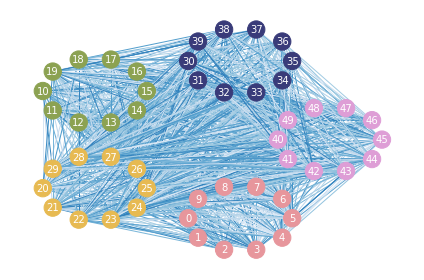

MYSCORE:  1219.2493960703473


In [28]:
G = read_input('./inputs/example.in')
solve(G)
validate_output(G)
visualize(G)
print ("MYSCORE: ", score(G))

In [29]:
run(solve, 'inputs/small37.in', 'outputs/small37.out', True)

/tmp/ipykernel_474597/1841718391.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G)


rguess:  [ 6  7  6 12  6 12  5 12  7  8 11  6  5  7 11  8  5  4  8  6 11 10 11  7
 10 12 10  1  5  8  4 10  2  1  2  6  7  5  4  1  6  8  2 12  4  3 12  2
  8  3 12  4  1 10  9 12 10  8  8 11  7  8  4  3 10 10  3  9 12  1  2 10
  1  9  9  3  6  3  7  9  1  1 12  4 10  8  9 12 12  2 12  9 12  3  3  4
  2  2  4  6] 
 WITH VALUE:  80458.28830732367
SCORE:  79203.86011531338
oBEST:  [6, 7, 6, 4, 6, 12, 5, 2, 7, 8, 11, 6, 5, 7, 11, 8, 5, 4, 8, 6, 11, 10, 11, 7, 10, 2, 10, 1, 5, 8, 4, 10, 2, 5, 2, 6, 7, 5, 4, 1, 6, 8, 2, 2, 4, 3, 12, 2, 8, 3, 12, 4, 1, 10, 2, 12, 10, 8, 8, 11, 7, 8, 4, 3, 10, 10, 3, 4, 12, 1, 2, 10, 1, 8, 4, 3, 6, 3, 7, 11, 1, 1, 12, 4, 10, 8, 12, 12, 12, 2, 12, 3, 12, 3, 3, 4, 2, 2, 4, 6]
inputs/small37.in: cost 79203.86011531338


In [ ]:
run_all(solve, 'inputs', 'outputs', True)
tar('outputs', True)

  0%|          | 0/781 [00:00<?, ?it/s]

abcurrent file:  outputs/medium109.out


/tmp/ipykernel_474597/1841718391.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G)


rguess:  [1 1 1 1 1 1 6 1 6 1 6 1 6 1 6 6 1 6 1 6 1 1 6 6 6 6 1 6 6 1 1 6 1 6 1 1 6
 6 4 4 6 1 4 6 4 4 1 6 4 4 1 4 6 1 4 1 4 1 4 4 6 7 1 4 7 6 1 4 7 7 1 6 4 6
 7 7 1 6 4 1 7 4 6 7 4 7 1 4 7 7 6 4 1 4 7 5 4 6 1 7 5 7 4 6 1 5 7 6 4 1 5
 4 5 7 5 6 4 1 5 7 1 6 5 5 1 7 5 5 4 7 1 6 5 4 7 5 1 6 5 7 5 7 5 4 7 5 5 1
 7 5 7 5 4 4 1 5 4 7 5 2 4 1 2 1 2 4 6 4 7 1 2 5 7 6 4 2 1 5 6 6 5 7 4 2 7
 4 5 2 7 6 5 2 5 7 4 2 1 6 4 7 2 4 6 2 2 7 4 5 6 2 6 1 2 7 6 1 4 2 7 5 3 6
 2 7 5 4 3 6 2 7 1 3 2 6 4 3 7 2 3 5 4 1 6 7 5 2 3 1 4 2 3 5 6 4 2 5 3 5 2
 2 5 1 7 3 5 4 5 2 6 1 5 5 3 7 3 6 5 1 3 7 1 5 2 5 5 5 1 1 5 5 2 1 4 5 3 5
 5 3 2 2] 
 WITH VALUE:  22446.75438310585
SCORE:  19040.984889924566
oBEST:  [1 1 1 1 1 1 6 1 3 1 6 1 6 1 6 6 1 6 1 6 1 1 6 6 5 6 1 6 6 1 1 6 1 6 1 1 6
 6 4 4 6 1 4 6 4 4 7 6 4 4 1 4 6 1 4 1 4 1 4 3 6 7 1 4 7 6 1 4 7 7 1 6 4 6
 7 7 1 6 7 1 7 4 6 7 4 7 1 4 7 7 6 4 1 4 7 5 4 6 1 7 5 7 4 6 1 5 7 6 4 1 5
 4 5 7 5 6 4 1 5 7 1 6 5 5 1 7 3 5 4 7 1 6 5 4 7 5 1 6 5 7 5 7 5 4 7 5 5 5
 7 5 7 5 4 4 

SCORE:  36762.82100246977
oBEST:  [ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 10 10  2 10
  2 10  2 10 10  2 10  2 10  3 10  2  3 10  3 10  3 10  2  3 10  2  3  2
  3 10  2  3  1  3  1 10  2  1  3 10  1 10  2  3  1 10  3  1  1  2 10  3
  1  2 10  3  2  2  1 10  3  1  1 10  3  2  1 10  3  2  3  1 10  3  1  2
 10  3  1 10  2  1  3 10  2  1 10  3  2  1  3 10  3 10  1  2  3  1 10 10
  1  2  3  1 10  1  2  3  3 10  1  2  1  1  3  3  2 10  1  2  3  1 10  2
  1  3  5  2 10  1  5  3  2  1 10  5  3  1  2 10  5  2  3  1  3  5 10  2
  5  1  3 10  5  5  2  1  5  3  2  1 10  5  3  2 10  1  5  2  3 10  3  5
 10  5  3  2  5 10  1  5  2 10  1  2  5  6 10  1  3  2  5  6  1  3  5  6
 10  2  1  6  5  3 10  2  6  5  1 10  6  5  2  3 10  6  6  3  6  1  5  2
  3 10  2  6  5  8  3  1 10  6  5  2  8 10  6  3  5  1  8 10  1  6  3  8
  5  2  1 10  6  8  5  2 10  6  8  3 10  8  2  5  3  6  8  1  5  2  6  8
 10  5  1  2  6  8  3  6  2  1  5 10  8  2  5  6  8  2  3 10  6  1  8  3
  8  8 10  5  6  

SCORE:  17120.270430968954
oBEST:  [6, 6, 6, 6, 8, 6, 8, 6, 6, 8, 8, 4, 4, 8, 9, 4, 9, 6, 4, 9, 3, 6, 9, 9, 8, 3, 3, 4, 9, 7, 4, 6, 4, 3, 7, 8, 3, 6, 4, 6, 7, 9, 3, 10, 10, 3, 4, 3, 8, 10, 7, 2, 9, 8, 10, 4, 7, 10, 10, 6, 7, 7, 10, 3, 4, 5, 2, 10, 5, 4, 2, 9, 8, 10, 5, 4, 6, 2, 7, 2, 7, 3, 4, 2, 9, 10, 2, 2, 5, 7, 2, 8, 7, 2, 3, 2, 8, 3, 8, 5, 6, 4, 9, 7, 7, 5, 2, 2, 8, 3, 8, 5, 6, 3, 9, 10, 7, 3, 2, 4, 8, 3, 8, 6, 6, 9, 9, 10, 7, 10, 2, 2, 8, 3, 6, 5, 6, 4, 9, 10, 7, 5, 7, 2, 8, 3, 8, 10, 6, 4, 9, 4, 7, 7, 6, 2, 5, 3, 7, 5, 6, 10, 10, 10, 7, 7, 2, 2, 8, 3, 10, 5, 6, 4, 9, 10, 7, 10, 2, 2, 8, 3, 2, 4, 6, 7, 5, 10, 7, 10, 2, 2, 8, 3, 8, 5, 6, 4, 9, 10, 7, 7, 2, 2, 8, 3, 8, 5, 6, 4, 9, 10, 7, 8, 2, 2, 8, 3, 4, 5, 6, 4, 9, 10, 7, 8, 8, 2, 8, 3, 8, 5, 6, 2, 5, 10, 7, 4, 5, 2, 8, 3, 8, 5, 6, 4, 9, 10, 7, 6, 9, 2, 8, 3, 8, 5, 7, 8, 9, 10, 7, 6, 7, 2, 8, 3, 5, 5, 6, 4, 9, 10, 7, 10, 2, 9, 8, 3, 10, 5, 6, 4, 9, 10, 7, 9, 2, 5, 5, 4, 8, 5, 6, 4, 9, 10, 4, 6, 2, 2, 8, 3, 8, 8, 6, 4, 9, 4, 7, 6, 

SCORE:  132616.67190349958
oBEST:  [ 5  5  9  5  9  5  9  5  9  5 12  9  5 12  9 12 12  9  4  5 12  4  9  4
  9  5  4  5  6 12  4 12  6  5 12  4  6  8  4 12  5  6  8  4  5 12  8  9
  6  6  8 12  5  4  8  6  4  8  9  7  8  7  6  3  5  1 12  9  4  7  6  8
  3  1  4 12  7  6  4  3  7  5  8  1 12  6  4  9  7  3  8  1  1  1  6  4
  9  7  3  1  3  7  4  3  1  5 10  8  7  6 10  1  3 12  5  9  4  8  7  6
 10  7 10  3 10 12  1  8  7 11  7  6 10  5 11 10  7  3  8 11  9  3  1  6
 13  7 10  4 11  6 13 10 12  8  3 13  1 11  8 13 10 11  5 11  7 13  9 12
  6  3 11 11  1  8 13 11 11  1 13 11  4 13 13  4  6  3  1  5 10  3 11 11
 10  3  8  4  1  9 11  3  3  7 11 11 13  1  9  3  6 11  3 12 10 13 13 11
 13 13  7  1  3 11  3 13 13  6  3  9 12  2  3 11 11  5 13 13  2  2  2  1
  3 12 11  4 13 13  3 12  2  5  3  4 10  3  7  3 13  5  6  3 13 11 11  2
 10 13  5  9 13  5 12 11  3  5  2  2 13  9  2 10  5 10  7  2  2 11 10  2
  4  3 10  3  2 13  2  2  5  8  5  1]
inputs/medium175.in: cost 132616.67190349958
abcurr

rguess:  [ 9 10  2  7  4  1  5  8  6  3  9 10  2  7  4  1  5  8  6  3  9 10  2  7
  4  1  5  8  6  3  9 10  2  7  4  1  5  8  6  3  9 10  2  7  4  1  5  8
  6  3  9 10  2  7  4  1  5  8  6  3  9 10  2  7  4  1  5  8  6  3  9 10
  2  7  4  1  5  8  6  3  9 10  2  7  4  1  5  8  6  3  9 10  2  7  4  1
  5  8  6  3  9 10  2  7  4  1  5  8  6  3  9 10  2  7  4  1  5  8  6  3
  9 10  2  7  4  1  5  8  6  3  9 10  2  7  4  1  5  8  6  3  9 10  2  7
  4  1  5  8  6  3  9 10  2  7  4  1  5  8  6  3  9 10  2  7  4  1  5  8
  6  3  9 10  2  7  4  1  5  8  6  3  9 10  2  7  4  1  5  8  6  3  9 10
  2  7  4  1  5  8  6  3  9 10  2  7  4  1  5  8  6  3  9 10  2  7  4  1
  5  8  6  3  9 10  2  7  4  1  5  8  6  3  9 10  2  7  4  1  5  8  6  3
  9 10  2  7  4  1  5  8  6  3  9 10  2  7  4  1  5  8  6  3  9 10  2  7
  4  1  5  8  6  3  9 10  2  7  4  1  5  8  6  3  9 10  2  7  4  1  5  8
  6  3  9 10  2  7  4  1  5  8  6  3  9 10  2  7  4  1  5  8  6  3  9 10
  2  7  4  1  5  8  6  3  9 10  2  7  4  1

SCORE:  1265769.1175468368
oBEST:  [0, 3, 1, 1, 1, 4, 5, 5, 0, 1, 4, 2, 5, 3, 0, 3, 1, 3, 4, 3, 3, 3, 5, 5, 0, 3, 4, 4, 3, 4, 2, 5, 2, 0, 0, 5, 2, 5, 2, 2, 2, 5, 2, 5, 2, 1, 4, 3, 1, 3, 3, 2, 3, 4, 3, 0, 5, 4, 0, 4, 5, 4, 2, 0, 2, 4, 0, 4, 0, 1, 5, 3, 3, 2, 4, 0, 0, 2, 3, 2, 3, 0, 1, 5, 3, 5, 3, 5, 4, 3, 3, 4, 3, 3, 3, 0, 2, 1, 3, 0, 2, 0, 2, 2, 4, 2, 2, 0, 1, 5, 2, 5, 3, 4, 0, 2, 0, 2, 3, 5, 5, 3, 5, 2, 5, 3, 4, 3, 4, 4, 0, 0, 2, 0, 1, 5, 0, 2, 5, 0, 3, 2, 2, 2, 0, 3, 5, 3, 2, 3, 0, 2, 2, 3, 5, 2, 5, 0, 0, 4, 3, 2, 5, 2, 3, 5, 1, 4, 1, 1, 0, 3, 5, 0, 4, 4, 4, 0, 0, 2, 0, 3, 5, 0, 4, 4, 3, 4, 1, 0, 4, 4, 3, 3, 0, 4, 0, 4, 1, 4, 5, 3, 0, 3, 3, 4, 4, 2, 4, 5, 3, 5, 0, 2, 3, 3, 3, 0, 3, 1, 3, 0, 4, 2, 5, 3, 5, 0, 5, 5, 0, 3, 5, 5, 2, 0, 0, 3, 4, 2, 3, 0, 0, 5, 0, 4, 5, 2, 4, 3, 0, 4, 2, 2, 2, 2, 3, 4, 0, 5, 4, 5, 4, 4, 2, 5, 2, 3, 3, 2, 0, 4, 3, 3, 3, 4, 5, 0, 5, 2, 2, 0, 4, 5, 0, 5, 3, 3, 2, 2, 0, 4, 3, 3, 3, 2, 2, 0, 3, 4, 5, 2, 5, 5, 3, 3, 4, 4, 5, 3, 5, 0, 3, 4, 5, 0, 0, 0, 3, 5, 0, 0

rguess:  [5 5 1 1 5 1 5 1 1 5 5 1 1 1 5 5 5 1 1 2 1 5 2 1 5 2 5 1 2 5 1 2 2 6 5 2 6
 5 6 2 6 5 1 2 6 1 8 6 1 8 6 2 1 8 6 8 6 8 2 6 8 5 8 1 6 3 3 8 2 5 1 6 3 6
 3 1 8 3 1 6 2 3 2 2 8 6 6 6 3 5 8 7 2 8 7 7 5 3 2 4 1 6 8 7 5 4 2 1 8 3 7
 4 1 6 5 2 3 8 7 4 2 5 8 1 7 3 4 8 2 5 7 6 3 8 4 2 7 5 6 3 8 4 1 2 7 3 8 6
 4 7 1 2 4 8 5 7 3 2 1 6 4 5 8 7 3 6 4 1 2 5 7 6 3 4 7 8 5 1 3 6 4 5 2 7 8
 3 6 1 4 5 7 3 2 8 6 4 5 1 2 4 7 3 8 1 5 6 2 4 7 3 8 1 4 6 5 2 7 3 1 4 2 8
 7 6 5 3 4 1 2 8 7 6 3 8 5 4 7 2 6 3 8 5 1 4 7 3 8 6 1 4 2 7 1 8 5 4 3 2 7
 6 4 5 1 3 8 6 7 4 2 5 3 6 1 7 4 8 5 3 1 6 7 4 2 7 8 5 6 1 3 4 7 1 2 8 6 5
 4 3 2 1] 
 WITH VALUE:  5495.3072283536485
SCORE:  5495.3072283536485
oBEST:  [5 5 1 1 5 1 5 1 1 5 5 1 1 1 5 5 5 1 1 2 1 5 2 1 5 2 5 1 2 5 1 2 2 6 5 2 6
 5 6 2 6 5 1 2 6 1 8 6 1 8 6 2 1 8 6 8 6 8 2 6 8 5 8 1 6 3 3 8 2 5 1 6 3 6
 3 1 8 3 1 6 2 3 2 2 8 6 6 6 3 5 8 7 2 8 7 7 5 3 2 4 1 6 8 7 5 4 2 1 8 3 7
 4 1 6 5 2 3 8 7 4 2 5 8 1 7 3 4 8 2 5 7 6 3 8 4 2 7 5 6 3 8 4 1 2 7 3 8 6
 4 7 1 2 4 8

SCORE:  35483.19954662428
oBEST:  [7, 1, 7, 8, 7, 7, 7, 7, 7, 1, 0, 8, 2, 5, 8, 7, 3, 1, 0, 5, 2, 8, 0, 2, 2, 0, 2, 5, 2, 5, 3, 2, 2, 1, 5, 1, 3, 3, 5, 5, 8, 2, 8, 8, 3, 0, 8, 0, 1, 3, 1, 5, 5, 3, 0, 0, 8, 3, 2, 3, 3, 8, 0, 2, 0, 0, 5, 5, 3, 0, 8, 2, 8, 0, 5, 2, 2, 2, 5, 3, 0, 8, 3, 8, 3, 5, 0, 0, 0, 5, 1, 5, 2, 8, 5, 0, 5, 7, 3, 3]
inputs/small86.in: cost 35483.19954662428
abcurrent file:  outputs/medium197.out
rguess:  [13  1  1 13 12 13  1 12  2  2  2  2 12  1 13  2 12 13  2  2  7  7 12  7
  2  7 13  2  9  7  9 12  1  8  2  9  1 13  8  9  7  2  8  4  2 13  7  1
  9  4  9  2 12 10 10  8  4 10  9  1  8 13 13 10 13 13  4  5  4 10  4  2
  8  5  8 13  3  5  4  3 11  9 11  2 11 13 10  6  6 10 12 13  1 12  5  1
  2 12  3 12  7 11  8  1 13  6  2  5  4 10  8 12  9 12  1  3 11  1  6 10
  7  5  8 13  2  3  4  1 11 12  6 13  1  2 12 10 13  7  9  3  1  6  8 12
 10 11 13  5  2  4  2 12  1  3  7 13  1  6  8 12 11 10  2  2 12  9  3  5
 13  6  4  1  1 12  2 11 12  2  3 10 13  9  5  1  6 11 12  4  8 

SCORE:  150675.38151439794
oBEST:  [7, 7, 7, 7, 5, 5, 5, 5, 7, 5, 7, 5, 7, 7, 5, 7, 5, 11, 7, 11, 7, 5, 11, 7, 11, 11, 7, 5, 11, 7, 12, 5, 11, 7, 12, 11, 12, 5, 7, 12, 5, 11, 12, 11, 5, 12, 7, 11, 5, 6, 12, 11, 6, 7, 11, 12, 6, 7, 12, 5, 6, 12, 5, 6, 7, 6, 7, 12, 11, 6, 7, 6, 5, 14, 7, 6, 12, 11, 14, 5, 12, 6, 7, 14, 14, 12, 7, 6, 5, 11, 14, 12, 7, 14, 6, 14, 5, 6, 14, 12, 6, 11, 13, 14, 12, 11, 13, 6, 14, 5, 13, 12, 6, 14, 13, 12, 11, 14, 5, 6, 13, 14, 13, 11, 13, 13, 12, 6, 13, 6, 5, 14, 7, 13, 6, 13, 2, 2, 12, 5, 13, 9, 14, 2, 13, 6, 12, 9, 2, 13, 11, 9, 14, 2, 9, 6, 13, 3, 7, 14, 2, 9, 5, 3, 2, 3, 9, 7, 3, 6, 2, 13, 9, 11, 9, 12, 3, 2, 13, 9, 5, 6, 14, 3, 2, 9, 7, 11, 2, 6, 5, 13, 5, 3, 9, 3, 13, 9, 1, 3, 14, 5, 11, 12, 7, 2, 9, 1, 2, 7, 6, 13, 3, 9, 1, 14, 5, 11, 2, 9, 3, 1, 7, 9, 6, 13, 2, 1, 12, 4, 10, 2, 3, 12, 4, 11, 14, 5, 9, 13, 1, 6, 3, 12, 4, 3, 2, 4, 13, 1, 2, 9, 4, 6, 3, 12, 13, 5, 2, 1, 14, 9, 3, 4, 9, 1, 12, 11, 5, 3, 13, 4, 14, 1, 11, 1, 7, 6, 2, 13, 10, 9, 12, 2, 3, 

rguess:  [ 6  6 11  6 11 11  6 11 11  7  7  6  6 11  7  3 11  6  3  7  1  3 11 11
  1  5  6  3  7 11 12  1  5  6  3  8  3 11  7  8  9 12  1  5  5 10  6  3
  8 11  4  9  7 12  1  8  6  3  5 10  3  8  4  8 11 12  1  9  3  6  9  5
  4 12 10  5  7  3  1 12 12  8  8  9 10  1  9  5 12  3 10  4  6 12  5 10
  3  1 12 10  4  8  8  7  1  2  9  9  5 10  3 10  3 12  1  2 11  6  4  3
  5  4 12 10  1  9  2  5 12  8  3  7  5  9 10 10  9  8  3 10  9  2  4  1
  5  9  4 10  3 11  6  1  3  6 12  7  9 12  8  2  7 12  3  5  7  6  5  9
 10 10  4  3  9 10  8  2  9  9  4  2  2  1  5  6  7  2  3  3  4  1  2  7
  6 12 11  1  9 10  2  8  5  2 12 12  6  2  7  3  5  9  6  5  4 10 10  2
  3 10  8  9  7  9  2  9  4  5  7  2  6  5  4  2  1  2  3  4  1  6  3 12
  1  1  7  8  4  2  5 12  9 10 12 11  3  2  2 10  2  6  6 12  4  2  9  5
 10  3  4  8  7  7 10 10  5  3 10  1  2  9  9  5  3  9  4  4  7  1  2  6
  5  4  3  2  2  1  3  4  4  3  2  1] 
 WITH VALUE:  247868.09101665427
SCORE:  225463.4598828962
oBEST:  [ 6  6 11

rguess:  [5 5 5 5 5 5 5 5 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5
 3 5 3 5 3 5 3 3 5 3 5 3 3 5 3 4 5 3 4 3 5 4 3 5 4 3 5 4 3 5 4 3 5 4 3 5 3
 4 5 3 4 3 5 4 5 3 4 5 3 4 5 3 4 5 3 4 3 5 4 3 5 4 3 5 4 3 5 4 3 5 4 3 5 4
 3 5 4 3 5 4 3 5 4 3 5 4 3 5 4 3 5 4 3 5 4 3 4 5 3 4 5 3 4 5 4 3 5 4 3 5 4
 5 3 4 5 3 4 5 3 4 5 4 3 5 4 3 5 4 3 5 4 5 3 5 4 3 5 4 3 5 4 3 5 4 3 4 3 5
 5 4 5 4 3 5 3 5 4 3 5 4 3 4 3 5 4 5 3 4 5 3 5 4 3 4 5 4 3 5 4 3 4 5 3 4 3
 5 4 3 4 5 4 4 3 4 5 3 4 5 3 2 5 4 3 2 5 4 3 5 2 3 4 2 2 5 3 2 4 5 3 2 5 4
 3 2 4 2 3 4 5 2 3 4 5 3 2 4 3 5 2 3 2 5 4 2 3 4 5 2 3 4 5 2 3 4 5 2 3 4 5
 2 5 3 2 4 5 3 2 5 2 3 4 2 3 5 4 5 2 3 4 2 5 4 2 5 3 4 2 3 4 5 2 3 4 5 2 3
 5 4 2 4 3 5 2 3 4 5 2 4 3 5 2 4 3 5 2 3 4 5 2 4 2 5 4 3 2 5 4 5 2 3 5 2 4
 5 4 4 3 2 5 4 3 2 5 4 3 5 2 4 3 5 2 4 3 5 2 3 4 2 5 3 4 2 5 3 4 2 5 3 4 4
 2 1 5 4 3 2 1 5 4 3 2 1 4 5 3 2 1 2 4 3 1 5 2 4 1 2 3 5 4 1 2 3 5 1 2 3 1
 5 2 3 4 1 5 2 4 3 1 2 5 4 3 1 2 4 1 5 2 3 4 1 5 2 1 4 2 3 5 1 4 3 2 5 1 4
 2 3 1 5 4 2 3 1

SCORE:  44701.36994490995
oBEST:  [ 3  3  3  3 10  3 10  3 10  3 10  3 10  3 10  3 10  3 10  3 10  3 10  3
 10  3 10  3 10 10  3 10 10  3 10  3 10  3 10  3 10  3 10 10  3  9 10  3
  9 10  3  9 10  9 10  3  9 10  3  9  3  9 10  9  9 10  3  9  3  9  3  9
 10  3  9 10  9  3 10  9  8  3  8  9 10  8  3  9 10  8  9  3 10  8  9 10
  8  3  9 10  8  9  3  9 10 10  8  9  3  8 10  9  9  8  3 10  9  8 10  9
  3 10  8 10  9  8  9  3  8 10  9 10  3  8  9  5  3  8  5  9  3  8  8 10
  5  9  3  8  5 10  8  9  5  8  5 10  3  8  5  3  9  5 10  8  3  9  5  5
  8  5 10  9  8  3  5 10  8  9  5 10  8  3  9  5  8 10  9  5  8  5  9  3
  5 10  8  3  9  5  8  3  9 10  5 11  5  3  9  8 11  5  3 10  9 11 10  8
  5  3 11  8  9 10  5 11  8  9 10  5 11 11  8  9  3 11  5  8  3 10  9 11
  5  3 10  8 11  5  9 10  5  9 11  8 11  5 10  3 11  9  8 10  3 11  5  9
  9  3  8 11  5 11  5 11  5 10  3  8  9 11 11  8  3  5 11 10  9  5  8 11
  5  9  3 10  8 11  5  2 11  5  9  2  3  5  8 10 11  2  3  9 10  5  2  5
  3 10  8 11  2  

SCORE:  18889.135722505427
oBEST:  [ 2  2  2  2  9  3  2  9  9  3  3  4  1  2  1  4  9  1  5  3  4  9  1  2
  5  9  4  2  5  1  3  4  9  1  5  4  8  9  8  5  3  4  1  2  8  3  4  5
  7  8  1  2  7  3  9  7  7 10  8  1  5  4 10 10  2  9  3  8  7  1 10  1
  5  4  6  6  8  6  1  6  1  8  6 10  3  8 10  5  8  1  6  8  6  8  6  7
 10  4  1  1]
inputs/small143.in: cost 18889.135722505427
abcurrent file:  outputs/small205.out
rguess:  [10  2  3 11  1  7  4  9  4 10  8  6 10  3  2  6  3  4 10  8  3  8  2  9
 11 11  2 12 12  9  6 12 10  5  3  5  6  4  2  1  5  2  8 12  9  6  4 12
  3  5  7 12  1  8  8  4  2  9  9  5  3  7  9  5  5  7 10  8  2  4  5  7
  3  8  5 10  1  9  5  5  8 12  9  2  8  6  7 11 12  7 10 12  6  8 10  7
  9 10  8  4] 
 WITH VALUE:  173334.4080180218
SCORE:  168841.9800856715
oBEST:  [ 3  2  3 11  1  7  4 11  4 10  8  6 10  3  2  6  3  4 10 11  3  8  2  9
 11 11 12 12 12  9  6 12 10  5  1  5  6  4  2  1  5  2  8  1  9  6  4 12
  3  5  7 12  1  8  8  4  2  9  9  5  1  1 10  5 

rguess:  [ 8 11  8  8 11  9  8  8  8  9  7 10  7  4 10 10 11  4  8  6 10 11  4 10
  7  8  3 12  2 10  6  7  9  1 10  2  5  4  5  5  6 11 12  7  1  3  4  5
  3 11  2  9 10  5 10  6  5  2  3  9 12  3  1 10  6  1  9  2  5  5 12  7
 11  1  1  9  2 10 10 12  3 12  9  9  6  4 10  5  6  6  4  1 12 12  7  9
  2 12  2  8] 
 WITH VALUE:  146873.57326047917
SCORE:  143327.30142345393
oBEST:  [ 8 11  8  8 11  9  8  8  8  9  7 10  7  4  3  3 11  4  8  6 10 11  4 10
  7  8  3 12  2 10  6  7  9  1 10  2  5  4  6  8  6  5 12  7  1  3  4  5
  3 11  2  9 10  5 10  6  5  2  3  9 12  3  1 10  6  1  9  2  5  5 12  7
 11  1  1  9  2 10 10 12  3 12  7  9 11  4 10  5  6  6  4  1 12 12  7  9
  2  7  2  8]
inputs/small197.in: cost 143327.30142345393
abcurrent file:  outputs/small132.out
rguess:  [ 6  4  8  9  8  1  7  2  4  7  7  1  9  1  2  1  4  3  4 11  8 11  8  3
  4  1  5  1  5  8  3 11  7  3  2  6 10  5  3  9  8  7  2  9  5  5  1  4
  3 10  6 10  2  2  5  1  9  5  9  2 10  3  4  7  5  5  6  3  4  5 11  7


SCORE:  38019.46918416806
oBEST:  [6, 5, 1, 0, 1, 10, 3, 2, 8, 1, 0, 5, 3, 10, 8, 6, 0, 4, 5, 2, 2, 3, 2, 0, 1, 8, 10, 6, 8, 4, 6, 1, 4, 3, 1, 4, 6, 6, 5, 8, 0, 5, 3, 2, 6, 4, 1, 4, 2, 0, 6, 6, 5, 3, 5, 2, 8, 10, 5, 6, 4, 1, 2, 8, 5, 10, 4, 0, 2, 4, 5, 8, 3, 10, 4, 1, 5, 10, 8, 10, 0, 8, 0, 6, 1, 0, 1, 10, 5, 4, 4, 8, 0, 10, 10, 6, 2, 3, 4, 8]
inputs/small83.in: cost 38019.46918416806
abcurrent file:  outputs/large220.out
rguess:  [ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3 11 11  3 11  3  1 11  1  3
 11  1 11  1  3 11  3  1 11  3  1  1 11  3  1 11  3  1 11  1  3 11  1  3
 10 11  1 10  3 11  1 10  1  3 11 10  1 11 10  3  1 10 11  1  3 10 11  1
  3 10 10 11 11  1  3 10 11  3  1 10 11  3  1 10 11 10  3 11  1 10 10  3
  1 10 11  3 10 10  1  1 11  3 10  1 11 10  1 11  3 10 10  3  1 11  7 10
  1 11  7  1  3 10  7 10  1 11  7  3 10  1 11  7  1 10  7 11  3  1 10  7
 11  3 10  1  7  1  3  7 11  1  7  1 10 11 10  3  7  1 10 11  7  1 10  3
  7  3  7  1 11  3 10  7  1  3 11  7  1 11  3 10  7 11

SCORE:  14251.654788997957
oBEST:  [3 3 2 3 3 3 3 3 3 3 1 3 3 3 3 2 3 3 2 3 3 3 3 3 3 1 3 4 2 4 4 1 4 3 3 3 4
 3 4 1 4 3 4 3 4 3 4 3 4 3 4 2 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 4 3 4 2 4 3 4
 3 2 3 4 3 4 3 4 3 4 3 3 3 4 3 4 2 4 1 1 3 4 3 2 2 4 3 4 3 4 3 2 3 4 3 4 3
 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 4 3 4 3 4 3 4 4 3 4 4 3 4 3 4 3 3 3 4 3
 4 1 4 3 4 3 4 3 1 4 3 1 4 1 1 4 3 1 3 4 1 3 4 1 3 4 1 3 1 1 3 4 1 3 4 1 3
 4 1 3 4 1 4 3 1 4 3 1 4 3 1 4 3 1 4 3 1 4 3 1 3 4 1 3 4 1 4 3 1 4 3 1 4 3
 2 4 1 3 4 1 3 4 1 3 1 4 3 3 4 3 1 4 3 1 4 3 1 4 4 4 4 3 1 4 3 1 4 3 1 4 3
 4 4 3 1 4 3 1 4 2 1 3 2 1 4 3 1 4 3 3 4 1 3 4 1 3 4 1 3 1 4 4 1 4 3 1 3 4
 1 4 3 2 4 3 1 4 3 4 1 3 4 1 3 4 1 3 4 1 3 4 1 3 4 1 3 1 2 3 1 4 3 1 4 3 1
 4 4 4 4 3 1 4 3 4 1 3 4 1 3 4 1 3 4 1 3 4 1 3 3 4 1 3 4 2 1 3 4 3 1 4 3 1
 4 3 1 3 4 1 3 4 1 3 4 1 3 4 1 3 4 1 4 3 2 4 1 3 1 3 4 1 4 3 1 4 3 4 1 2 4
 3 1 2 3 1 2 1 3 1 4 3 4 1 1 4 1 4 3 2 1 3 3 1 4 3 1 3 1 4 3 1 4 3 1 4 2 1
 4 3 3 1 3 1 2 4 1 3 1 1 3 4 1 3 4 1 3 4 1 3 4 1 3 4 1 3 4 4 1 3 

rguess:  [10 10  6  6 11 10 10  6  6 10  2 10 11 10 11  1  2  5 11  5 10  6 10 10
  1 11  7  8  3 11  4 10  1  2  9  5  3  9  5  5  3  6  9  4  9  5 10  3
  4  4  4  8  1  1  5  1  7 11  7 11  3  6 10  7  1  5  3 11  3  1  3  4
  3  8 11  6 10  9  5  5 11  3 11  1  8  2  8  7  9  8  3  3  8  1  3 10
  9  1  1  1] 
 WITH VALUE:  108667.9746299363
SCORE:  99229.96319484094
oBEST:  [10 10  6  6 11 10 10  6  6 10  2 10 11  2  6  1  2  5 11  5 11  6 10 10
  1 11  7  8  3  7  2  6  1  2  9  5  3  9  5  5  8  6  9  4  9  5 10  3
  4  4  5  8  1  1  5  5  7 11  7 11  3  7 10  7  2  5  4 11  3  1  3  4
  3  8 11  6 10  9  5  5 11  9 11  1  8  2  8  7 10  8  3  3  8  1  3 10
  9  1  1  1]
inputs/small127.in: cost 99229.96319484094
abcurrent file:  outputs/medium99.out
rguess:  [3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3
 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4
 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4 2 1 3 4

rguess:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2] 
 WITH VALUE:  272.8281828459045
SCORE:  272.8281828459045
oBEST:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2

SCORE:  282548.2409150045
oBEST:  [ 9  4  9  4  9  4  9  4  9  4  8  5  9  9  5  4  4  5  4  5  5  9  5  9
 10  9  5  9  5  9  4  9  5  9  4  9  3  6  3  3  3  3  3  8  5  5  5  5
  1  1 11  1 12  1 10  1  9  4 10  1  5  3  3 12  3  7  9 12  1 10  8  2
  7 12  2  9  1  3  9  9  1  7  9  4  5  6  4 10  7  2 11  8  7  7 11 12
  1 11  7 10 12  3  2 12  2  6  1  8  2 10  5 12  3  2  6  8  4 12  3  7
  7  1  7 12 12  6  3 12  3  6 12 10 10 12  1 12 10  3  4  6  9  7  1  2
  9 10  6  8 10  8 11  7  2  7  6  9  1 12  1  1 12  8 11  8  5  1 11 11
 10  3  6  7  8  1 12 11 10  9 10  2 10  6  8 12 10  1 10 12  8  6 10  5
 11  8 10  9  2  8  1 12  2 11  6  7  1  7 12  9  6  8  3  6 12  3 12  4
  2 10  9 12  7  3  7  1 11  9  6  3  4  1 10  6 10  9  8  7  7 12 10 12
  3 12  3  8  4 11 10  7  1  7  3  2 10 10  2 10  9  5 12 12  9  7  8  1
  1  1  7  8  7  7  6  3 12  1  2  1  8  6  7  6 12  3 11  4 12  2  7 12
  7  3 10  8  1  2  8  2  3  5  3  3]
inputs/medium252.in: cost 282548.2409150045
abcurren

SCORE:  386855.68982795556
oBEST:  [2, 6, 6, 7, 8, 1, 12, 2, 1, 1, 9, 3, 9, 9, 8, 11, 11, 13, 10, 7, 10, 10, 3, 4, 4, 8, 8, 12, 11, 10, 11, 13, 4, 13, 7, 9, 9, 11, 4, 11, 6, 11, 7, 8, 6, 13, 3, 7, 3, 3, 8, 7, 4, 9, 11, 11, 7, 3, 8, 7, 4, 11, 6, 1, 9, 1, 6, 11, 8, 11, 9, 11, 2, 10, 9, 11, 4, 4, 3, 3, 6, 3, 6, 10, 11, 3, 2, 11, 8, 4, 4, 3, 2, 9, 10, 11, 4, 13, 2, 3, 11, 7, 10, 3, 3, 8, 9, 1, 10, 1, 10, 12, 4, 3, 9, 10, 11, 9, 8, 4, 6, 9, 10, 6, 3, 9, 4, 8, 4, 11, 10, 11, 3, 7, 3, 6, 4, 1, 7, 4, 8, 8, 3, 6, 3, 8, 7, 3, 11, 3, 8, 3, 3, 8, 7, 7, 9, 2, 3, 4, 1, 4, 10, 4, 6, 3, 2, 10, 7, 6, 9, 4, 9, 6, 1, 3, 3, 7, 3, 9, 4, 10, 3, 8, 3, 6, 13, 2, 12, 9, 8, 12, 11, 7, 4, 7, 4, 7, 9, 7, 2, 3, 6, 3, 7, 1, 6, 3, 7, 4, 8, 6, 1, 3, 10, 8, 11, 4, 7, 11, 13, 8, 4, 4, 8, 8, 4, 9, 9, 10, 10, 7, 9, 7, 10, 12, 11, 11, 8, 10, 10, 3, 13, 4, 12, 3, 2, 9, 3, 8, 4, 3, 3, 6, 10, 1, 6, 3, 1, 13, 3, 3, 9, 11, 4, 3, 6, 6, 11, 6, 12, 1, 11, 8, 8, 8, 11, 4, 9, 8, 3, 2, 6, 3, 3, 7, 7, 3, 9, 10, 8, 11, 7, 8, 4, 2, 10,

rguess:  [12 12  2 12  2  5  5  2 12  5  2 12  5  2 11 12 11 11  7  2 12  5 11  7
 11  7  2 12  7  5 11  7  6  2 11  6  6 12  5  6  7 11  6 12  6  2  6  5
  6  2  7  1 12  6  6  2  1  6  5  1  6  7  2  6 11  5 12  1  1  6  6 11
 11  6  1 10  5 10  7  1  6 11 11  8  1 10 11 11 10  8  6 11 12  1  5 10
  6 11  7  8  5 11  6  8  4 10  7  1  8 11  4  8 12  3  4 10 11  2  3  5
  6  2  8  2  8 11  3  4  6  2  8 11  2  6 11  8  3 10  1  8 13  4 11  8
  5 13  2  4  7 10 13  9  3  5 10 12 13  2  4  6  8  6  9 13  3  2  1  8
 13  4  7 12 11 11  6  9 13  2  3  2 13  4  9  3  2  4  9 10  8  9 10 10
  3  9  1  6  8  4  3  8  4 13 10 10  2  8  7  4 11  3  4 10  9  3  4  2
  4  1  8  5  9  6 10  4  8  3 13  4  4  9  3  2 13  3  1  4  1 13 12  4
 12  6  3  3 13  1  9  1  4 12  9  4  3  4  1  3 13  4  9  1  9  8  3  7
 11  9  9  1  3  4 13 13  4 13 11  9  1 13  1 12  9  4 13  2 13  1  3 13
  1  3  8  3 10  4 12  9  3  1  4  1] 
 WITH VALUE:  240728.77298879082
SCORE:  236603.8718740521
oBEST:  [12 12  2

rguess:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1

SCORE:  46451.6146413554
oBEST:  [ 3  5  2 10  8  7  9 11  8 12  7  4  6  7  5  2  8  3  5 10  9 10 11 12
  3  4  5  1 11  6  2 10  4  3  5 12  1  4  6  2  8  3  9 11  1  5  6 10
  2  9  1 12  4  3 10  2 11  8  5  9  1 12  4  6  2  1 12 11  1 12  1  6
 10  3  9  1  2  5  1  5  8  9  6  2  4 11  1 12  6 11  5  3 10  1  8 12
  5  3  8  9  3 12  4 11  5 12  2  9  3 12  1  4  1 11 12  5  1 10  6  9
  4  8  1  3  2  5 10  1  1 12  4  2  3 10  1  5 11  9  6  3  1 12 10  1
  8  5  2  6  3 12 11 10  1  9  6  8  1  7  9  5  4 10  3 11  1  2  4  5
  3  9  1  5 12  6  1  7 10  5 11  1 12  5  1  1  3  6  2  9 10  4  5 12
  1 11  2  6  1  1  1  4 12  9  2  6 11  1  8  2  3 11 12  4  9  1  5 10
 11  1  1  5  6  2  4  9  3  1 12 11  8  5  6  4  1  2  4  7  9 10 12  5
 11  1  2  3  4 12  1  6  9 10  4  3  5 11  1  2 12  4 10  5 11  9  1  8
  6  3 12  1  2 10  1  4  9  5 11  6  3 12  2  1  8  2 10  1  6  4 11  2
  9  1  3  2 12  4  6  1  5  1  2 11 10 12  8  9  1  3  4 11  2  6 12 10
  1  9  3  1 12  7

SCORE:  2016.4055032898657
oBEST:  [3 3 3 3 3 3 3 3 3 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5
 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6
 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4
 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3
 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2
 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1
 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5
 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6 4 3 2 1 5 6
 4 3 2 1]
inputs/medium115.in: cost 2016.4055032898657
abcurrent file:  outputs/medium182.out
rguess:  [ 5  5  5  1  1  5  1  5  1  5 11  1 11 11  1 11  7  1  5 11  1  7  7  5
 11  7 11 11  2  2  1 11  2  5  2  2 11  5  7 11 11  7  2  2  1  5 11 11
  7 11  2  1 11  7  5 11  1  2  7  5 11  7  2 12 11 12  7 12 12  1 12  2
 11  7  3  3  2 11  3 12  3  1  3  5 12 12 